# Bungee Jumping Drop

Shreya Chowdhary & Gail Romer


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton

<Unit('newton')>

We used google to find the average weight for a human, approximated the diameter of a spherical human by curling in balls and measuring ourselves, found k value for bungee cord from https://bungeejournal.academic.wlu.edu/files/2014/11/Does-a-Bungee-Cord-Behave-Like-an-Ideal-Spring.pdf

drag coefficient of a sphere: https://en.wikipedia.org/wiki/Drag_coefficient

mass bungee taken from the jump notebook (?)

In [3]:
def make_system(params):
    init = State(h = params.init_height, 
                 v = 0 * m/s)
    area = np.pi * (params.diameter/2)**2
    mu = params.mass_bungee/(params.mass_human + params.mass_object)
    system = System(params, init = init, area = area, mu = mu)
    return system

In [4]:
def drag_force(v, system):
    unpack(system)
#     print(v)
    return -np.sign(v) * rho * v**2 * C_d * area / 2
#     return 0 

In [5]:
def whip_force(system, state):
    unpack(system)
    h, v = state
    a = np.sign(v)*(mu * (v**2)/2)/(mu*(bungee_rest_length + h) + 2*bungee_rest_length)
#     return total_mass*a
    return 0

In [6]:
def spring_force(h, system):
    unpack(system)
    return k*((init_height - h) - bungee_rest_length)

In [7]:
def free_fall_event(state, t, system):
    unpack(system)
    h, v = state
    
    return bungee_rest_length - (init_height - h)

In [8]:
def slope_stage_14(state, t, system): #Stages 1 & 4 involve the same forces
    unpack(system)
    h, v = state
    
    f_drag = drag_force(v, system)
    f_whip = whip_force(system, state)
    f_grav = (total_mass)*(-g)

    net_force = f_drag + f_whip + f_grav
    a = net_force/total_mass
    dhdt = v
    dvdt = a 
    
    return dhdt, dvdt

In [9]:
def slope_stage_23(state, t, system):
    unpack(system)
    h, v = state
    f_drag = drag_force(v, system)
    f_spring = spring_force(h, system)
    f_grav = (total_mass)*(-g)
    
#     print(v, f_drag)
#     print(h, f_spring)
    
    net_force = f_drag + f_spring + f_grav
    a = net_force/total_mass
    dhdt = v
    dvdt = a
    
    return dhdt, dvdt

### Stage 1: Freefall

In [10]:
def plot_height(heights, stage):
    plot(heights)
    title = "Height v.s. Time for " + stage
    decorate(title = title, xlabel="Time (s)", ylabel="Height (m)")

In [11]:
def plot_velocity(velocities, stage):
    plot(velocities)
    title = "Velocity v.s. Time for " + stage
    decorate(title = title, xlabel="Time (s)", ylabel="Velocity (m/s)")

In [12]:
def free_fall(sys):
    unpack(sys)
    system = System(sys, total_mass = sys.mass_human + sys.mass_object)
    free_fall_results, details = run_ode_solver(system, slope_stage_14, events = free_fall_event, max_step = dt)
    
    h_final = get_last_value(free_fall_results.h) * m
    v_final = get_last_value(free_fall_results.v) * m/s
    
    if p:
        plot_height(free_fall_results.h, "Free Fall Stage")
        plt.figure()
        plot_velocity(free_fall_results.v, "Free Fall Stage")
    
    free_fall_state = State(h = h_final, v = v_final)
    
    t_final = get_last_label(free_fall_results) * s
    
    system = System(system, init = free_fall_state, t_0 = t_final)
    
    return system, free_fall_results

### Stage 2: Stretch

In [13]:
def stretch_event(state, t, system):
    unpack(system)
    h, v = state
    return v

In [14]:
def stretch(sys):
    unpack(sys)
    stretch_results, details = run_ode_solver(sys, slope_stage_23, events = stretch_event, max_step = dt)
#     print(stretch_results.h)
    
    h_final = get_last_value(stretch_results.h) * m
    v_final = get_last_value(stretch_results.v) * m/s
    
    if p:
        plot_height(stretch_results.h, "Stretch Stage")
        plt.figure()
        plot_velocity(stretch_results.v, "Stretch Stage")
    
    stretch_state = State(h = h_final, v = v_final)
    
    t_final = get_last_label(stretch_results) * s
    
    system = System(sys, init = stretch_state, t_0 = t_final)
    
    return system, stretch_results
        
# final_V_of_freefall = 20 * m/s
# final_height_of_freefall = 100 * m
# t = 20 * s

# delta_Y = 220 * m - final_height_of_freefall


# F_g = -(params.mass_human+params.mass_object)*params.g
# F_bungee = -params.k*(delta_Y - params.bungee_rest_length) # NEED TO MAKE THIS A FUNC OF DT
# # F_drag
# a = -(F_bungee - F_g)/(params.mass_human+params.mass_object)
# v = final_V_of_freefall + a*dt
# height = final_height_of_freefall + v*dt


# # EPE_of_Bungee = (1/2)*params.k*delta_Y

# #End characteristic of Stage 2 => (v = 0)
# # return Final Height of Stretch Stage, final V of stretch stage, final t of stretch stage, EPE of Bungee

### Stage 3: Release
is this a necessary stage?

In [15]:
def return_event(state, t, system):
    unpack(system)
    h, v = state
    
    return (init_height - h) - bungee_rest_length

In [16]:
def bungee_return(sys):
    unpack(sys)
    sys = System(sys,total_mass = mass_human)
    return_results, details = run_ode_solver(sys, slope_stage_23, events = return_event, max_step = dt)
#     print(return_results.h)

    h_final = get_last_value(return_results.h) * m
    v_final = get_last_value(return_results.v) * m/s

    if p:
        plot_height(return_results.h, "Return Stage")
        plt.figure()
        plot_velocity(return_results.v, "Return Stage")

    return_state = State(h = h_final, v = v_final)
    
    t_final = get_last_label(return_results) * s
    
    system = System(sys, init = return_state, t_0 = t_final)
    
    return system, return_results

### Stage 5: Freefly

In [17]:
def free_fly_event(state,t,system):
    unpack(system)
    h, v = state
    return v

In [18]:
def free_fly(sys):
    unpack(sys)
    system = System(sys, total_mass = sys.mass_human + sys.mass_object)
    free_fly_results, details = run_ode_solver(system, slope_stage_14, events = free_fly_event, max_step = dt)
    
    h_final = get_last_value(free_fly_results.h) * m
    v_final = get_last_value(free_fly_results.v) * m/s

    if p:
        plot_height(free_fly_results.h, "Free Fly Stage")
        plt.figure()
        plot_velocity(free_fly_results.v, "Free Fly Stage")
    
    free_fly_state = State(h = h_final, v = v_final)
    
    t_final = get_last_label(free_fly_results) * s
    
    system = System(system, init = free_fly_state, t_0 = t_final)
    
    return system, free_fly_results

### End Stage: Pass Height 0

In [19]:
params = Params(init_height = 220 * m,
                g = 9.8 * m/s**2,
                mass_human = 62 * kg,
#                 mass_object = 10 * kg,
                mass_object = 0 * kg,
                diameter = 0.8128 * m, # diameter of a spherical human
                rho = 1.2 * kg/m**3,   # rho of air for drag calculations
                k = 40 * N/m,      # k value for an average bungee cord
                bungee_rest_length = 100 * m, # bungee cord less than half of init_height FOR NOW
                t_0 = 0 *s,
                t_end = 2000 * s,
                dt = 0.1*s,
#                dt = .01*s, # will use for final essay
               C_d = 0.47,
               mass_bungee = 75 * kg,
               p=False)

,values
init_height,220 meter
g,9.8 meter / second ** 2
mass_human,62 kilogram
mass_object,0 kilogram
diameter,0.8128 meter
rho,1.2 kilogram / meter ** 3
k,40.0 newton / meter
bungee_rest_length,100 meter
t_0,0 second
t_end,2000 second


In [20]:
def bungee_drop(mass, params):

    params = Params(params, mass_object = mass)
    system = make_system(params)
    
    free_fall_system, free_fall_results= free_fall(system)
    stretch_system, stretch_results = stretch(free_fall_system)
    return_system, return_results = bungee_return(stretch_system)
    free_fly_system, free_fly_results= free_fly(return_system)

    return get_last_value(free_fly_results.h) * m - params.init_height

In [21]:
bungee_drop(50*kg, params)

<Quantity(24.082336331230692, 'meter')>

In [22]:
def sweep_mass(params):
    mass_series = TimeSeries()
    mass_array = linrange(10,200,10)
    print(mass_array)
    
    for mass in mass_array:
        m = mass * kg
        results = bungee_drop(m,params)
        mass_series[mass] = results
    plot(mass_series)
 




[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190]


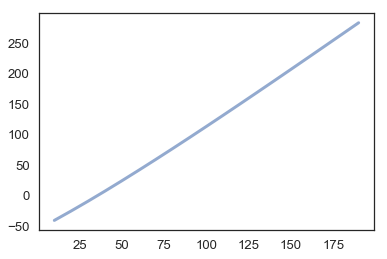

In [23]:
sweep_mass(params)


In [ ]:
mass = fsolve(bungee_drop, 70*kg, params)[0]*kg


2832.77164776532


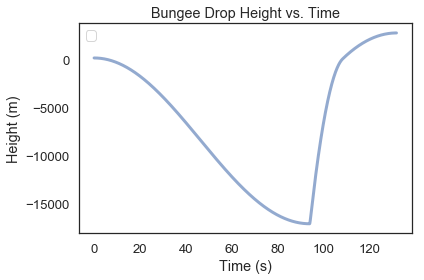

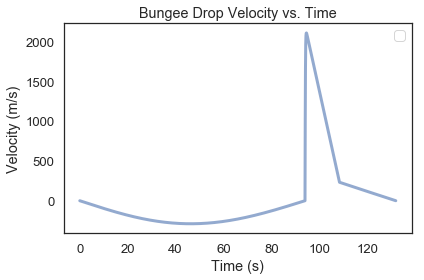

In [28]:

def plot_final(mass, params):
    params = Params(params, mass_object = mass)
    system = make_system(params)

    free_fall_system, free_fall_results= free_fall(system)
    stretch_system, stretch_results = stretch(free_fall_system)
    return_system, return_results = bungee_return(stretch_system)
    free_fly_system, free_fly_results= free_fly(return_system)
    
    frames = [free_fall_results, stretch_results, return_results, free_fly_results]
    result = pd.concat(frames)

    plot(result.h)
    decorate(title = "Bungee Drop Height vs. Time", ylabel = "Height (m)", xlabel = "Time (s)", legend = mass)

    plt.figure()
    plot(result.v)
    decorate(title = "Bungee Drop Velocity vs. Time", ylabel = "Velocity (m/s)", xlabel = "Time (s)", legend = mass)
    print(get_last_value(result.h))
plot_final(mass,params)


In [29]:
print(mass)

35700.36691145813 kilogram


NameError: name 'results' is not defined